In [3]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
%pip install --user -Uqq fastai duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


In [5]:
#from duckduckgo_search import ddg_images
from fastcore.all import *
import time
import json

def search_images(term, max_images=30):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')    
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [6]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('cricket ball', max_images=1)
urls[0]

'https://cdn.cnn.com/cnnnext/dam/assets/180326063740-cricket-balls-stock-super-tease.jpg'

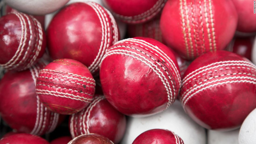

In [8]:
from fastdownload import download_url
dest = 'cricket_ball.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
download_url(search_images('baseball balls', max_images=5)[2], 'baseball.jpg', show_progress=False)
Image.open('baseball.jpg').to_thumb(256,256)

The code below is used to create new folders and fill them with search results searched by 'searches'.

In [10]:
searches = 'baseball','cricket'
path = Path('dog_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
#    dest.mkdir(exist_ok=True, parents=True)
    # download_images(dest, urls=search_images(f'{o} photo'))
    # sleep(10)  # Pause between searches to avoid over-loading server
    # download_images(dest, urls=search_images(f'{o} sun photo'))
    # sleep(10)
    # download_images(dest, urls=search_images(f'{o} shade photo'))
    # sleep(10)
    # resize_images(path/o, max_size=400, dest=path/o)

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

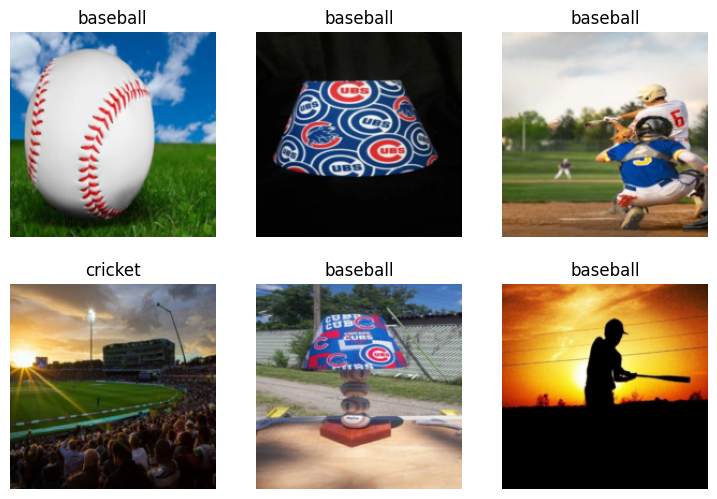

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.222442,1.041382,0.406250,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.622527,0.692216,0.250000,00:12
1,0.455811,0.702087,0.281250,00:12
2,0.337585,0.756865,0.312500,00:12


In [17]:
is_cricket,_,probs = learn.predict(PILImage.create('cricket_bat.jpeg'))
print(f"This is related to : {is_cricket}.")
print(f"Probability it's related to baseball: {probs[0]:.4f}")

This is related to : cricket.
Probability it's related to baseball: 0.0071
